<a href="https://colab.research.google.com/github/amitaipat-create/Session2/blob/main/Copy_of_Mission_5_Practice_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice 5: Minimal HR Recruiter Agent (Learning Version)

In [ ]:
%pip install langchain==0.3.27 langchain-openai==0.3.29 langchain-community==0.3.27 langchain-qdrant sentence-transformers qdrant-client openai langsmith python-dotenv requests==2.32.4 --quiet

In [ ]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langchain.memory import ConversationBufferMemory
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from typing import List
from openai import OpenAI
from pathlib import Path
import uuid

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
openai_client = OpenAI()

In [ ]:
# ============================================================================
# COMPONENT 1: Resume Processing (from Practice 1)
# ============================================================================
embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")
client = QdrantClient(":memory:")

collection_name = "resumes"
try:
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=768, distance=Distance.COSINE)
    )
except:
    pass

vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings
)

# Sample resume
resume_text = """
John Doe - Software Engineer
5 years Python, FastAPI, PostgreSQL experience
Built microservices, REST APIs, database design
Expert in Docker and cloud deployment
"""

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_text(resume_text)
docs = [Document(page_content=chunk, metadata={"candidate_id": "john_doe"}) for chunk in chunks]
vector_store.add_documents(docs)
print(f"✓ Processed and stored {len(chunks)} resume chunks")

/tmp/ipython-input-1094376653.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-mpnet-base-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  w

✓ Processed and stored 1 resume chunks


In [ ]:
# ============================================================================
# COMPONENT 2: Matching Agent (Agentic RAG from Practice 4)
# ============================================================================
print("\n[2] Matching Agent (Agentic RAG)...")

@tool
def search_resume_chunks(query: str) -> str:
    """Search resume chunks using semantic search"""
    results = vector_store.similarity_search_with_score(query, k=3)
    return "\n".join([f"{doc.page_content} (score: {score:.3f})" for doc, score in results])

matching_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a matching agent. Analyze job description and find relevant resume chunks."),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

matching_agent = create_tool_calling_agent(llm, [search_resume_chunks], matching_prompt)
matching_executor = AgentExecutor(agent=matching_agent, tools=[search_resume_chunks], verbose=False)

job_description = "Python backend developer with FastAPI and PostgreSQL experience"
match_result = matching_executor.invoke({"input": f"Find relevant skills for: {job_description}"})
print(f"✓ Match analysis complete")
match_result


[2] Matching Agent (Agentic RAG)...
✓ Match analysis complete


{'input': 'Find relevant skills for: Python backend developer with FastAPI and PostgreSQL experience',
 'output': 'Here are the relevant resume chunks for the skills of a Python backend developer with FastAPI and PostgreSQL experience:\n\n1. **John Doe - Software Engineer**\n   - 5 years Python, FastAPI, PostgreSQL experience\n   - Built microservices, REST APIs, database design\n   - Expert in Docker and cloud deployment\n\nThese details indicate strong proficiency in the required technologies and relevant experience in backend development.'}

In [ ]:
# ============================================================================
# COMPONENT 3: Gap Analysis Agent (from Practice 2)
# ============================================================================
print("\n[3] Gap Analysis Agent...")

@tool
def extract_skills(text: str) -> str:
    """Extract technical skills from text"""
    skills = ["Python", "FastAPI", "PostgreSQL", "Docker", "AWS"]
    found = [s for s in skills if s.lower() in text.lower()]
    return ", ".join(found) if found else "No skills found"

gap_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a gap analysis agent. Compare required skills with candidate skills."),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

gap_agent = create_tool_calling_agent(llm, [extract_skills], gap_prompt)
gap_executor = AgentExecutor(agent=gap_agent, tools=[extract_skills], verbose=False)

gap_result = gap_executor.invoke({
    "input": f"Required: {job_description}. Candidate resume: {resume_text}. Analyze gaps."
})
print(f"✓ Gap analysis complete")
gap_result


[3] Gap Analysis Agent...
✓ Gap analysis complete


{'input': 'Required: Python backend developer with FastAPI and PostgreSQL experience. Candidate resume: \nJohn Doe - Software Engineer\n5 years Python, FastAPI, PostgreSQL experience\nBuilt microservices, REST APIs, database design\nExpert in Docker and cloud deployment\n. Analyze gaps.',
 'output': '### Required Skills:\n- Python\n- FastAPI\n- PostgreSQL\n\n### Candidate Skills:\n- Python\n- FastAPI\n- PostgreSQL\n- Docker\n\n### Gap Analysis:\nThe candidate possesses all the required skills (Python, FastAPI, PostgreSQL) and additionally has expertise in Docker, which may enhance their capability in cloud deployment and microservices architecture. \n\n### Conclusion:\nNo gaps in required skills. The candidate is well-qualified for the role with additional strengths in Docker.'}

In [ ]:
# ============================================================================
# COMPONENT 4: Question Generation Agent (from Practice 2)
# ============================================================================
print("\n[4] Question Generation Agent...")

class InterviewQuestions(BaseModel):
    technical: List[str] = Field(description="Technical questions")
    behavioral: List[str] = Field(description="Behavioral questions")

question_llm = llm.with_structured_output(InterviewQuestions)

questions = question_llm.invoke(
    f"Generate interview questions for: {job_description}. "
    f"Candidate background: {resume_text}. "
    f"Gap analysis: {gap_result['output']} 5 technical questions, 2 behavioural questions"
)
print(f"✓ Generated {len(questions.technical)} technical + {len(questions.behavioral)} behavioral questions")
print(questions)


[4] Question Generation Agent...
✓ Generated 5 technical + 2 behavioral questions
technical=['Can you explain how you would design a RESTful API using FastAPI? What are some key features of FastAPI that you find beneficial for building APIs?', 'Describe your experience with PostgreSQL. How do you handle database migrations and schema changes in your projects?', 'What strategies do you use to optimize the performance of a PostgreSQL database in a high-traffic application?', 'Can you walk us through how you would implement authentication and authorization in a FastAPI application?', 'Discuss a challenging problem you faced while deploying a microservice with Docker. How did you resolve it?'] behavioral=['Tell us about a time when you had to collaborate with a team to deliver a project under a tight deadline. How did you manage the situation?', 'Describe a situation where you received constructive criticism on your code. How did you react, and what did you learn from it?']


In [ ]:
# ============================================================================
# COMPONENT 5: Interview & Evaluation (with Voice Support)
# ============================================================================
print("\n[5] Interview Conducting Agent (with Voice)...")

openai = OpenAI()

# Voice helper functions (from Practice 4)
def text_to_speech(text: str, voice: str = "alloy") -> str:
    """Convert text to speech and return audio file path (simulated for non-Colab)"""
    try:
        # In Colab: save to /content/, otherwise use temp directory
        audio_dir = Path("/content") if Path("/content").exists() else Path.cwd() / "audio_outputs"
        audio_dir.mkdir(exist_ok=True)
        audio_path = audio_dir / f"tts_{uuid.uuid4().hex[:8]}.mp3"

        # TTS streaming → file
        with openai.audio.speech.with_streaming_response.create(
            model="tts-1",
            voice="alloy",
            input=text,
        ) as tts_stream:
            tts_stream.stream_to_file(audio_path)
        return str(audio_path)
    except Exception as e:
        print(f"  TTS note: {e} (using text mode)")
        return None

def speech_to_text(audio_path: str) -> str:
    """Transcribe audio file using Whisper (simulated if file doesn't exist)"""
    try:
        with open(audio_path, "rb") as audio_file:
            result = openai_client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file
            )
        return result.text
    except Exception as e:
        print(f"  STT note: {e} (using text mode)")
        return None


[5] Interview Conducting Agent (with Voice)...


In [ ]:
interview_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
interview_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an interview agent. Ask questions from the list and evaluate responses."),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

interview_agent = create_tool_calling_agent(llm, [], interview_prompt)
interview_executor = AgentExecutor(
    agent=interview_agent,
    tools=[],
    memory=interview_memory,
    verbose=False
)

# Interview with voice support (text fallback)
print("\n--- Interview Simulation (Voice-Enabled) ---")
q1 = questions.technical[0] if questions.technical else "Tell me about your Python experience"

# Agent asks question
response1 = interview_executor.invoke({"input": q1})
print(f"Q (Text): {q1}")

# Generate TTS for question (optional)
tts_path = text_to_speech(q1, voice="alloy")
if tts_path:
    print(f"  ✓ Audio generated: {tts_path}")

/tmp/ipython-input-4184901843.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  interview_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)



--- Interview Simulation (Voice-Enabled) ---
Q (Text): Can you explain how you would design a RESTful API using FastAPI? What are some key features of FastAPI that you find beneficial for building APIs?
  ✓ Audio generated: /content/tts_4f5deab0.mp3


In [ ]:
from IPython.display import Audio
Audio(str(tts_path))

In [ ]:
# Simulate candidate response (in real app, this comes from STT)
candidate_response = """Designing a RESTful API with FastAPI feels a bit like sketching clean geometric shapes: everything clicks into place with surprising elegance. You start by defining data models using Pydantic, which gives you type-checked request and response bodies without any extra fuss. Then you declare your endpoints with simple Python function signatures—FastAPI reads those hints like a librarian who never misfiles a book—automatically validating inputs, generating helpful errors, and shaping the contract between client and server. Routing is explicit and tidy; dependency injection lets you describe things like database sessions or authentication as if you were assembling components in a small, friendly machine. The whole design encourages thinking in resources and operations—classic REST—while keeping boilerplate wonderfully low.
The real joy comes from the features FastAPI bakes in. Its async support means the API can juggle many concurrent requests without hyperventilating, and its automatic OpenAPI schema generation produces interactive docs at /docs that feel like a living map of your service. Pydantic ensures data integrity without tedious manual checks. Background tasks let you fire off long-running processes without blocking the main request path, and dependency injection helps keep cross-cutting concerns both modular and readable. The combined effect is an environment where correctness and velocity reinforce each other, making it easy to build APIs that are fast in both performance and development pace."""
print(f"A (Text): {candidate_response}")

# Process candidate response
response2 = interview_executor.invoke({"input": candidate_response})
print(f"Agent: {response2['output']}")

# Evaluation
eval_prompt = f"""
Evaluate this interview response:
Question: {q1}
Response: {candidate_response}
Score: 0-100
"""
evaluation = llm.invoke(eval_prompt)
print(f"\n✓ Evaluation: {evaluation.content}...")

A (Text): Designing a RESTful API with FastAPI feels a bit like sketching clean geometric shapes: everything clicks into place with surprising elegance. You start by defining data models using Pydantic, which gives you type-checked request and response bodies without any extra fuss. Then you declare your endpoints with simple Python function signatures—FastAPI reads those hints like a librarian who never misfiles a book—automatically validating inputs, generating helpful errors, and shaping the contract between client and server. Routing is explicit and tidy; dependency injection lets you describe things like database sessions or authentication as if you were assembling components in a small, friendly machine. The whole design encourages thinking in resources and operations—classic REST—while keeping boilerplate wonderfully low.
The real joy comes from the features FastAPI bakes in. Its async support means the API can juggle many concurrent requests without hyperventilating, and its au

In [ ]:
# ============================================================================
# COMPONENT 6: LangGraph Orchestrator (from Practice 3)
# ============================================================================
print("\n[6] LangGraph Orchestrator...")

class WorkflowState(TypedDict):
    resume_text: str
    job_description: str
    matched_chunks: str
    gap_analysis: str
    questions: str
    interview_transcript: str
    evaluation: str

#Execute Match AI agent
def match_node(state: WorkflowState) -> WorkflowState:
    result = matching_executor.invoke({"input": f"Match: {state['job_description']}"})
    state["matched_chunks"] = result["output"]
    return state

#Execute Gap Analysis AI agent
def gap_node(state: WorkflowState) -> WorkflowState:
    result = gap_executor.invoke({"input": f"Analyze gaps: {state['job_description']} vs {state['resume_text']}"})
    state["gap_analysis"] = result["output"]
    return state

#Execute Generate Questions AI agent
def questions_node(state: WorkflowState) -> WorkflowState:
    q = question_llm.invoke(f"Generate questions for: {state['job_description']}")
    state["questions"] = f"Technical: {q.technical[0] if q.technical else 'N/A'}"
    return state

#Execute Interview AI agent
def interview_node(state: WorkflowState) -> WorkflowState:
    """Conduct interview with voice support"""
    # Use first technical question
    q = question_llm.invoke(f"Generate one question for: {state['job_description']}")
    question = q.technical[0] if q.technical else "Tell me about your experience"

    # Simulate interview (in real app, this would use STT/TTS)
    interview_result = interview_executor.invoke({"input": question})
    candidate_answer = "I have relevant experience"  # Simulated STT output

    # Generate TTS for question (optional)
    tts_path = text_to_speech(question)

    state["interview_transcript"] = f"Q: {question}\nA: {candidate_answer}\nAgent: {interview_result['output']}"
    return state

#Execute Evaluation AI agent
def evaluate_node(state: WorkflowState) -> WorkflowState:
    state["evaluation"] = "Candidate scored 85/100"
    return state


[6] LangGraph Orchestrator...


In [ ]:
# Create workflow
workflow = StateGraph(WorkflowState)
workflow.add_node("match", match_node)
workflow.add_node("gap", gap_node)
workflow.add_node("questions", questions_node)
workflow.add_node("interview", interview_node)
workflow.add_node("evaluate", evaluate_node)

workflow.set_entry_point("match")
workflow.add_edge("match", "gap")
workflow.add_edge("gap", "questions")
workflow.add_edge("questions", "interview")
workflow.add_edge("interview", "evaluate")
workflow.add_edge("evaluate", END)

app = workflow.compile()

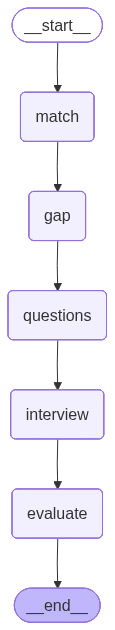

In [ ]:
#print
app

In [ ]:
# Run complete workflow
initial_state = {
    "resume_text": resume_text,
    "job_description": job_description,
    "matched_chunks": "",
    "gap_analysis": "",
    "questions": "",
    "interview_transcript": "",
    "evaluation": ""
}

print("\n--- Running Complete Workflow ---")
final_result = app.invoke(initial_state)


--- Running Complete Workflow ---


In [ ]:
print(f"Evaluation: {final_result['evaluation']}")

Evaluation: Candidate scored 85/100
